<a href="https://colab.research.google.com/github/won-hj/deep_learning_study/blob/main/nmt/nmt_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural machine translation with attention

이 노트북을 기반으로 영어 번역 스페인어 순서 (seq2seq) 모델과 일련의 훈련 [주의 기반 신경 기계 번역에 접근 효과를](https://arxiv.org/abs/1508.04025v5) .
<table>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/RNN%2Battention-words-spa.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>This tutorial: An encoder/decoder connected by attention.</th>
<tr>
</table>
이 아키텍처는 다소 오래된 동안 그것은 (에에 가기 전에주의 메커니즘의 깊은 이해를 얻을 수있는을 통해 작업에 매우 유용한 프로젝트 여전히 [트랜스포](https://www.tensorflow.org/text/tutorials/transformer?hl=ko&_gl=1*eeepfb*_up*MQ..*_ga*ODI4OTI5NTIyLjE3Mzk1MDE1NjM.*_ga_W0YLR4190T*MTczOTUwMTU2My4xLjAuMTczOTUwMTU2My4wLjAuMA..) ).


이것은 다음 사항에 대한 지식이 있다고 가정하는 고급 예입니다.

* Sequence to sequence 모델
* keras 레이어 아래의 TensorFlow 기본 사항:
  * [텐서로 직접 작업하기](https://www.google.com/url?q=https%3A%2F%2Fwww.tensorflow.org%2Fguide%2Ftensor)
  * [사용자 정의 작성 `keras.Model` 들과 `keras.layers`](https://www.google.com/url?q=https%3A%2F%2Fwww.tensorflow.org%2Fguide%2Fkeras%2Fcustom_layers_and_models)



"? ¿ todavia estan 엉 카사"이 노트북 모델을 훈련 한 후에는 같은 스페인의 문장을 입력 할 수 및 영어 번역 반환합니다 : "집에서 아직도를"

생성 된 모델은 같은 내보낼 `tf.saved_model` 가 TensorFlow 다른 환경에서 사용될 수 있도록.

번역 품질은 장난감 예에 적합하지만 생성된 주의 플롯이 더 흥미로울 수 있습니다. 이것은 번역하는 동안 입력 문장의 어느 부분이 모델의 주의를 끌었는지 보여줍니다.

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

참고 :이 예제는 하나의 P100의 GPU에서 실행하기 위해 약 10 분 정도 소요됩니다.




## 설정

In [1]:
!pip install "tensorflow-text>=2.11"
!pip install einops

In [2]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

이 튜토리얼은 처음부터 몇 개의 레이어를 빌드합니다. 사용자 정의 구현과 내장 구현 간에 전환하려면 이 변수를 사용하세요.

In [3]:
use_builtins =True #?

이 튜토리얼은 셰이프를 틀리기 쉬운 저수준 API를 많이 사용합니다. 이 클래스는 튜토리얼 전체에서 모양을 확인하는데 사용됩니다.

In [74]:
#@title
class ShapeChecker():
  def __init_(self):
    #keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    '''
    if isinstance(names, str):
      names = (names, )

    shape = tf.shape(tensor)
    rank = tf.ranf(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'   found {rank}: {shape.numpy()}\n'
                       f'   expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

    if (broadcast and new_dim == 1):
      continue

    if old_dim is None:
      #if the axis name is new, add its elngth to the cache
      self.shapes[name] = new_dim
      continue

    if new_dim != old_dim:
      raise ValueError(f'Shape mismatch for dimension: "{name}"\n'
      f'   found: {new_dim}\n'
      f'   expected: {old_dim}\n')
    '''
    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(names, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        #if the axis name is new, add its elngth to the cache
        self.shapes[names] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f'Shape mismatch for dimension: "{names}"\n'
        f'   found: {new_dim}\n'
        f'   expected: {old_dim}\n')


In [81]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    print(f'parsed: {parsed}')
    print(f'self.shapes 0: {self.shapes}')
    for name, new_dim in parsed.items():
      print(f'self.shapes: {self.shapes}')
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## 데이터

우리가 제공하는 언어 데이터 세트 사용합니다 http://www.manythings.org/anki/ 이 데이터 세트는 형식 언어 번역 쌍을 포함를:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

그들은 다양한 언어를 사용할 수 있지만 우리는 영어-스페인어 데이터 세트를 사용할 것입니다.

### 데이터세트 다운로드 및 준비

편의를 위해 Google Cloud에서 이 데이터세트의 사본을 호스팅했지만 자체 사본을 다운로드할 수도 있습니다. 데이터 세트를 다운로드한 후 데이터를 준비하기 위해 수행할 단계는 다음과 같습니다.
1. 각 문장에 토큰 시작과 끝을 추가합니다.
2. 특수 문자를 제거하여 문장을 정리합니다.
3. 단어 색인 및 역단어 색인을 작성하십시오(단어->id 및 id->단어에서 사전 매핑).
4, 각 문장을 최대 길이로 채웁니다.

압축해제

In [30]:
import zipfile

#/root/.keras/datasets/spa-eng.zip
def unzip_files(path_of_zip, name_of_zip):
  zip_file = path_of_zip / name_of_zip
  print(zip_file)
  if zip_file.exists():
    with zipfile.ZipFile(zip_file, 'r') as zip_ref: #zipfile
      zip_ref.extractall(path_of_zip) #path

In [31]:
#Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    #extract=True
)
print(path_to_zip)

path_of_zip = pathlib.Path(path_to_zip).parent
print(path_of_zip)

unzip_files(path_of_zip, 'spa-eng.zip')
path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'
#No such file or directory: '/root/.keras/datasets/spa-eng/spa.txt'

/root/.keras/datasets/spa-eng.zip
/root/.keras/datasets
/root/.keras/datasets/spa-eng.zip


In [10]:
print(path_to_zip)

/root/.keras/datasets/spa-eng_extracted


In [8]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  '''inp = [inp for targ, inp in pairs]
  targ = [targ for targ, inp in pairs]

  return targ, inp'''
  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

In [33]:
#targ, inp = load_data(path_to_file)
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1] )#if context_raw else inp[-1]
print()
print(target_raw[-1] ) #if target_raw else targ[-1]

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


### tf.data 데이터세트 만들기



문자열이 배열에서 당신은 만들 수 있습니다 [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=ko&_gl=1*1rrf9ph*_up*MQ..*_ga*ODI4OTI5NTIyLjE3Mzk1MDE1NjM.*_ga_W0YLR4190T*MTczOTUwMTU2My4xLjAuMTczOTUwMTU2My4wLjAuMA..) 그 섞어 배치 그들을 효율적으로 문자열을 :

In [35]:
#targ: target_raw
#inp: context_raw

BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

#dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
#dataset = dataset.batch(BATCH_SIZE)

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw  = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

In [40]:
print(f'train_raw: {train_raw.element_spec}', end='\n',sep=' ')
print(f'val_raw: {val_raw}')

train_raw: (TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))
val_raw: <_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


In [41]:
##                                  #' dataset ' -> train_raw/ val_raw
for ex_input_batch, ex_target_batch in dataset.take(1):
  print(ex_input_batch[:5])
  print()
  print(ex_target_batch[:5])
  break

tf.Tensor(
[b'Lo le\xc3\xad a mi familia.' b'Hizo alarde de valor.'
 b'Su muerte fue en parte mi culpa.'
 b'Puede que no sepa mucho, pero s\xc3\xad s\xc3\xa9 que Tom no sabe de lo que est\xc3\xa1 hablando.'
 b'\xc3\x89l sigui\xc3\xb3 cantando.'], shape=(5,), dtype=string)

tf.Tensor(
[b'I read it to my family.' b'He boasted of his courage.'
 b'His death was partly my fault.'
 b"I may not know a lot, but I do know that Tom doesn't know what he's talking about."
 b'He kept singing.'], shape=(5,), dtype=string)


In [42]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'\xc2\xbfQuedamos para ma\xc3\xb1ana?'
 b'No hizo Tom nada m\xc3\xa1s que comer.' b'Tengo todo.'
 b'No me agrada la idea de que el dinero sea todo.'
 b'Eisenhower mantuvo su promesa.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Are we meeting tomorrow?' b'All Tom did was eat.' b'I have everything.'
 b"I don't like the idea that money is everything."
 b'Eisenhower kept his promise.'], shape=(5,), dtype=string)


### 텍스트 전처리

이 튜토리얼의 목표 중 하나는로 내보낼 수 있습니다 모델 구축하는 것입니다 [`tf.saved_model`](https://www.tensorflow.org/api_docs/python/tf/saved_model?hl=ko&_gl=1*1l83uhq*_up*MQ..*_ga*ODI4OTI5NTIyLjE3Mzk1MDE1NjM.*_ga_W0YLR4190T*MTczOTUwMTU2My4xLjAuMTczOTUwMTU2My4wLjAuMA..) . 그 수출 모델을 편리하게 사용할 수 있도록하기 위해이해야 [`tf.string`](https://www.tensorflow.org/api_docs/python/tf?hl=ko&_gl=1*1nqs6rn*_up*MQ..*_ga*ODI4OTI5NTIyLjE3Mzk1MDE1NjM.*_ga_W0YLR4190T*MTczOTUwMTU2My4xLjAuMTczOTUwMTU2My4wLjAuMA..#string) 입력을 반환 [`tf.string`](https://www.tensorflow.org/api_docs/python/tf?hl=ko&_gl=1*1nqs6rn*_up*MQ..*_ga*ODI4OTI5NTIyLjE3Mzk1MDE1NjM.*_ga_W0YLR4190T*MTczOTUwMTU2My4xLjAuMTczOTUwMTU2My4wLjAuMA..#string) 출력 : 모든 텍스트 처리는 모델 내부에서 발생합니다.

#### 표준화

이 모델은 어휘가 제한된 다국어 텍스트를 다루고 있습니다. 따라서 입력 텍스트를 표준화하는 것이 중요합니다.

첫 번째 단계는 악센트가 있는 문자를 분할하고 호환성 문자를 해당 ASCII 문자로 바꾸는 유니코드 정규화입니다.

`tensorflow_text` 패키지는 유니 코드 정규화 작업을 포함 :

In [43]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


유니코드 정규화는 텍스트 표준화 기능의 첫 번째 단계가 될 것입니다.

In [47]:
def tf_lower_and_split_punct(text):
  #split accecented characters
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  #keep space, a-z and select punctuation
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')# '[& a-z.?!,¿]'
  #add spaces around punctuation
  text = tf.strings.regex_replace(text,'[.?!,¿]', r' \0 ') # '[.?!,¿]'
  #strip whitespace
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [48]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


#### 텍스트 벡터화

이 표준화 함수는 싸서한다 [`tf.keras.layers.TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization?hl=ko&_gl=1*168ghyd*_up*MQ..*_ga*ODI4OTI5NTIyLjE3Mzk1MDE1NjM.*_ga_W0YLR4190T*MTczOTUwMTU2My4xLjAuMTczOTUwMTU2My4wLjAuMA..) 토큰 서열 어휘 추출 및 입력 텍스트의 변환을 처리 층.

In [54]:
max_vocab_size = 5000
#input_
context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True
)

`TextVectorization` 층 및 기타 전처리 층은 [Kers preprocessing layers](https://www.google.com/url?q=https%3A%2F%2Fwww.tensorflow.org%2Fguide%2Fkeras%2Fpreprocessing_layers)가지고 `adapt` 방법. 이 방법은 훈련 데이터의 한 시대를 읽고, 같은 많은 작업 `Model.fix` . 이 `adapt` 방법은 데이터에 기초 층을 초기화한다. 여기에서 어휘를 결정합니다.

In [56]:
#input_text_processor.adpat(inp)
context_text_processor.adapt(train_raw.map(lambda target, context: context))

#here are the first 10 words from the vocabulary
#input_text_processor.get_vocabualary()[:10]
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

즉 스페인의 `TextVectorization` 구축하고 현재 레이어 `.adapt()` 영어 하나

In [57]:
#output_text_processor = tf.keras.layers.TextVectorization(
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

#output_text_processor.adapt(targ)
#output_text_processor.get_vocabulary()[:10]
target_text_processor.adapt(train_raw.map(lambda target, context: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [61]:
print(f' context_text_processor: \n{context_text_processor.get_vocabulary()}')
print(f' target_text_processor: \n{target_text_processor.get_vocabulary()}')

 context_text_processor: 
['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom', 'a', '?', 'is', 'he', 'in', 'of', 'that', 'it', ',', 'was', 'do', 'me', 'this', 'have', 'my', 'for', 'she', 'dont', 'are', 'what', 'his', 'your', 'mary', 'we', 'on', 'be', 'with', 'want', 'not', 'im', 'and', 'like', 'at', 'know', 'him', 'can', 'go', 'her', 'has', 'will', 'its', 'they', 'there', 'time', 'were', 'as', 'did', 'how', 'had', 'very', 'all', 'here', 'up', 'about', 'think', 'didnt', 'get', 'out', 'from', 'if', 'cant', 'when', 'an', 'no', 'one', 'going', 'doesnt', 'by', 'would', 'come', 'why', 'see', 'good', 'ill', 'youre', 'please', 'who', 'just', 'been', 'so', 'need', 'more', 'help', 'tell', 'than', 'where', 'but', 'now', 'never', 'got', 'too', 'am', 'something', 'us', 'some', 'take', 'ive', 'should', 'last', 'much', 'car', 'day', 'money', 'could', 'work', 'home', 'people', 'well', 'back', '!', 'went', 'really', 'said', 'our', 'house', 'told', 'book', 'lot', 'many', 'anything', 'a

이제 이러한 레이어는 문자열 배치를 토큰 ID 배치로 변환할 수 있습니다.

In [62]:
#example_tokens = input_text_processor(example_input_batch)
#example_tokens[:3, :10]
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :10]

<tf.RaggedTensor [[2, 1, 1, 1, 1, 11, 3], [2, 73, 1, 9, 1, 1, 1, 1, 4, 3], [2, 1, 1, 4, 3]]>

`get_vocabulary` 방법은 텍스트로 다시 토큰 ID를 변환 할 수 있습니다 :

In [63]:
#input_vocab = np.array(input_text_processor.get_vocabulary())
#tokens = input_vocab[example_tokens[0].numpy()]
#''.join(tokens)
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] [UNK] [UNK] [UNK] [UNK] ? [END]'

반환된 토큰 ID는 0으로 채워집니다. 이것은 쉽게 마스크로 바뀔 수 있습니다.

Text(0.5, 1.0, 'Mask')

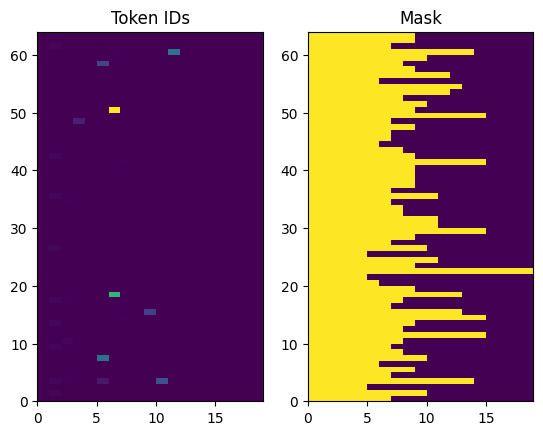

In [64]:
plt.subplot(1,2,1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1,2,2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

### Process the dataset

The `process_text` function below converts the `Datasets` of strings, into  0-padded tensors of token IDs. It also converts from a `(context, target)` pair to an `((context, target_in), target_out)` pair for training with `keras.Model.fit`. Keras expects `(inputs, labels)` pairs, the inputs are the `(context, target_in)` and the labels are `target_out`. The difference between `target_in` and `target_out` is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [70]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[: , :-1].to_tensor()
  targ_out = target[:, 1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

Here is the first sequence of each, from the first batch:

In [71]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

[ 2  1  1  1  1 11  3  0  0  0]

[ 2  1  1  1  1  1  1 12  0  0]
[ 1  1  1  1  1  1 12  3  0  0]


## 인코더/디코더  


위 다이어그램의 파란색 부분인 인코더를 빌드하는 것으로 시작합니다.

인코더:

1. (에서 토큰 ID 목록을 취 input_text_processor ).
2. 각 토큰에 대한 내장 벡터 조회 (A 사용 layers.Embedding ).
3. 새로운 시퀀스에 묻어 (A 사용하여 처리 layers.GRU ).
4. 보고:
  * 처리된 시퀀스입니다. 이것은 주의 헤드로 전달됩니다.
  * 내부 상태입니다. 디코더를 초기화하는 데 사용됩니다.

<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg"/>
  </td>
  <td>
   <img width=380 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The original from <a href=https://arxiv.org/abs/1508.04025v5>Effective Approaches to Attention-based Neural Machine Translation</a></th>
  <th colspan=1>This tutorial's model</th>
<tr>
</table>


Before getting into it define constants for the model:

In [65]:
UNITS = 256

### The encoder

The goal of the encoder is to process the context sequence into a sequence of vectors that are useful for the decoder as it attempts to predict the next output for each timestep. Since the context sequence is constant, there is no restriction on how information can flow in the encoder, so use a bidirectional-RNN to do the processing:

<table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <th>A bidirectional RNN</th>
<tr>
</table>

The encoder:

1. Takes a list of token IDs (from `context_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a bidirectional `layers.GRU`).
5. Returns the processed sequence. This will be passed to the attention head.

In [66]:
######
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    #the embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    #the GRU RNN layer processses those vectors sequentially
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   #return the sequence and sate
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    #2. the embedding layer looks up the embedding for each token
    vectors = self.embedding(tokens)
    shape_checker(vector, ('batch', 's', 'embed_dim'))

    #3 the gru processes the embedding sequence
    #  output shape: (batch, s, enc_units)
    #  state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    #4 returns the new sequence and its state
    return output, state


class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # the embedding layer converts tokens to vector
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

    #the rnn layer processes those vectors sequentially
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode = 'sum',
        layer = tf.keras.layers.GRU(units,
                                    #return the sequence and state
                                    return_sequence=True,
                                    recurrent_initializer='glorot_uniform')
    )

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    #2 the embedding layer look up the embedding vector for each token
    s = self.embedding(x)
    shape_checker(x, 'batch s uits')

    # the gru processes the sequence of embeddings
    x = self.rnn(x)
    shape_cehcker(x, 'batch s units')

    #4 return the new sequence of embedding
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

이것이 지금까지 어떻게 일치하는지입니다.

In [75]:
##
#convert the input text to tokens
example_tokens = input_text_processor(example_input_batch)

#encode the input sequence
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')


#Encoder the input sequence
encoder = Encoder(input_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

NameError: name 'example_input_batch' is not defined

---
코랩튜토리얼

In [111]:
# 튜토리얼 코랩 코드
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor,units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = max_vocab_size#text_processor.vocabulary_size() #여기서 processor의 vocab_size를 가져오는 이유????? -> 2
    print(f'init__vocab_size {self.vocab_size}')
    self.units = units

    #the embeddiing layer converts tokens to vectors
    #vocab_size는 self인데 unit은 self가 아니다 ? ?
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    #the rnn layer processes those sequentially
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode = 'sum',
        layer = tf.keras.layers.GRU(units,
                                    #return the sequence and state
                                    return_sequences=True,
                                    recurrent_initializer='glorot_uniform')
    )

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')
    print('#1 done')
    #2. the embedding layer looks up the embedding vector for each token
    print()
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    print('#2 done')
    #3. the gru processes the sequence of embeddings
    x = self.rnn(x)
    shape_checker(x, 'batch s units')
    print('#3 done')
    #4. returns the new sequence of embeddings
    print('#4 done')
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [112]:
print(f'ex_context_tok {ex_context_tok}')
print(f'ex_context_tok min {tf.reduce_min(ex_context_tok)}')
print(f'ex_context_tok max {tf.reduce_max(ex_context_tok)}')

print(f'max vocab size {max_vocab_size}')
print(f'processor vocab size {input_text_processor.vocabulary_size()}')

ex_context_tok [[ 2  1  1 ...  0  0  0]
 [ 2  1 10 ...  0  0  0]
 [ 2  1  1 ...  0  0  0]
 ...
 [ 2  1  1 ...  0  0  0]
 [ 2  1  1 ...  0  0  0]
 [ 2  1  1 ...  0  0  0]]
ex_context_tok min 0
ex_context_tok max 3356
max vocab size 5000
processor vocab size 2


In [137]:
#try it out

#encode th input sequence
encoder = Encoder(input_text_processor, UNITS)
ex_context = encoder(ex_context_tok)
#
'''
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393:
UserWarning:
  `build()` was called on layer 'encoder_4',
  however the layer does not have a `build()` method implemented and it looks like it has unbuilt state.
  This will cause the layer to be marked as built, despite not being actually built,
  which may cause failures down the line. Make sure to implement a proper `build()` method.
'''

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

init__vocab_size 5000
#1 done

#2 done
#3 done
#4 done
parsed: {'batch': 64, 's': 20}
self.shapes 0: {}
self.shapes: {}
self.shapes: {'batch': 64}
#1 done

parsed: {'batch': 64, 's': 20, 'units': 256}
self.shapes 0: {'batch': 64, 's': 20}
self.shapes: {'batch': 64, 's': 20}
self.shapes: {'batch': 64, 's': 20}
self.shapes: {'batch': 64, 's': 20}
#2 done


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'encoder_16', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


parsed: {'batch': 64, 's': 20, 'units': 256}
self.shapes 0: {'batch': 64, 's': 20, 'units': 256}
self.shapes: {'batch': 64, 's': 20, 'units': 256}
self.shapes: {'batch': 64, 's': 20, 'units': 256}
self.shapes: {'batch': 64, 's': 20, 'units': 256}
#3 done
#4 done
Context tokens, shape (batch, s): (64, 20)
Encoder output, shape (batch, s, units): (64, 20, 256)


인코더는 해당 상태를 디코더 초기화에 사용할 수 있도록 내부 상태를 반환합니다.

RNN이 여러 호출을 통해 시퀀스를 처리할 수 있도록 상태를 반환하는 것도 일반적입니다. 디코더를 만드는 과정을 더 많이 보게 될 것입니다.

### The attention layer

The attention layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output.

The simplest way you could calculate a single vector from the entire sequence would be to take the average across the sequence (`layers.GlobalAveragePooling1D`). An attention layer is similar, but calculates a **weighted** average across the context sequence. Where the weights are calculated from the combination of context and "query" vectors.

<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The attention layer</th>
<tr>
</table>


디코더는 주의를 사용하여 입력 시퀀스의 일부에 선택적으로 초점을 맞춥니다. Attention은 각 예제에 대한 입력으로 벡터 시퀀스를 사용하고 각 예제에 대해 "attention" 벡터를 반환합니다. 이 관심 층은 비슷 `layers.GlobalAveragePoling1D` 하지만 관심 층은 **가중 평균**을 행한다.

작동 방식을 살펴보겠습니다.

<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The attention layer</th>
<tr>
</table>

In [116]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True
    )

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # cache the attention scores for plotting layer
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [119]:
attention_layer = CrossAttention(UNITS)

# attend to the enceded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                 output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

parsed: {'batch': 64, 't': 19, 'units': 256}
self.shapes 0: {}
self.shapes: {}
self.shapes: {'batch': 64}
self.shapes: {'batch': 64, 't': 19}
parsed: {'batch': 64, 's': 20, 'units': 256}
self.shapes 0: {'batch': 64, 't': 19, 'units': 256}
self.shapes: {'batch': 64, 't': 19, 'units': 256}
self.shapes: {'batch': 64, 't': 19, 'units': 256}
self.shapes: {'batch': 64, 't': 19, 'units': 256, 's': 20}
parsed: {'batch': 64, 't': 19, 'units': 256}
self.shapes 0: {'batch': 64, 't': 19, 'units': 256, 's': 20}
self.shapes: {'batch': 64, 't': 19, 'units': 256, 's': 20}
self.shapes: {'batch': 64, 't': 19, 'units': 256, 's': 20}
self.shapes: {'batch': 64, 't': 19, 'units': 256, 's': 20}
parsed: {'batch': 64, 'heads': 1, 't': 19, 's': 20}
self.shapes 0: {'batch': 64, 't': 19, 'units': 256, 's': 20}
self.shapes: {'batch': 64, 't': 19, 'units': 256, 's': 20}
self.shapes: {'batch': 64, 't': 19, 'units': 256, 's': 20}
self.shapes: {'batch': 64, 't': 19, 'units': 256, 's': 20, 'heads': 1}
self.shapes: {'ba

The attention weights will sum to `1` over the context sequence, at each location in the target sequence.

In [120]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([0.9999999, 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       ], dtype=float32)



Here are the attention weights across the context sequences at `t=0`:

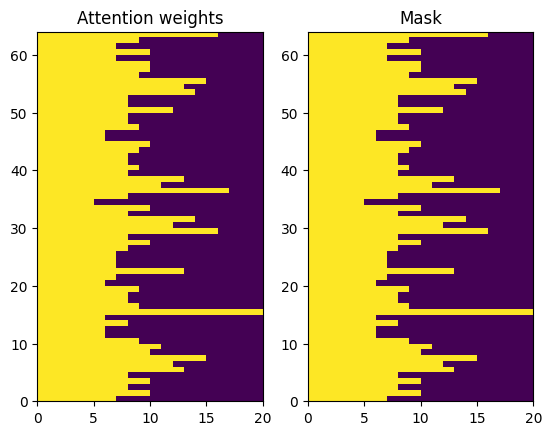

In [122]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1,2,1)
plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


Because of the small-random initialization the attention weights are initially all close to `1/(sequence_length)`. The model will learn to make these less uniform as training progresses.

##### attention head

디코더는 주의를 사용하여 입력 시퀀스의 일부에 선택적으로 초점을 맞춥니다. Attention은 각 예제에 대한 입력으로 벡터 시퀀스를 사용하고 각 예제에 대해 "attention" 벡터를 반환합니다. 이 관심 층은 비슷 `layers.GlobalAveragePoling1D` 하지만 관심 층은 가중 평균을 행한다.


<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/text/tutorials/images/attention_equation_1.jpg?hl=ko"/>
  </td>
</tr>
<tr>
  <th>A unidirectional RNN</th>
<tr>
</table>

<table>
<tr>
  <td>
   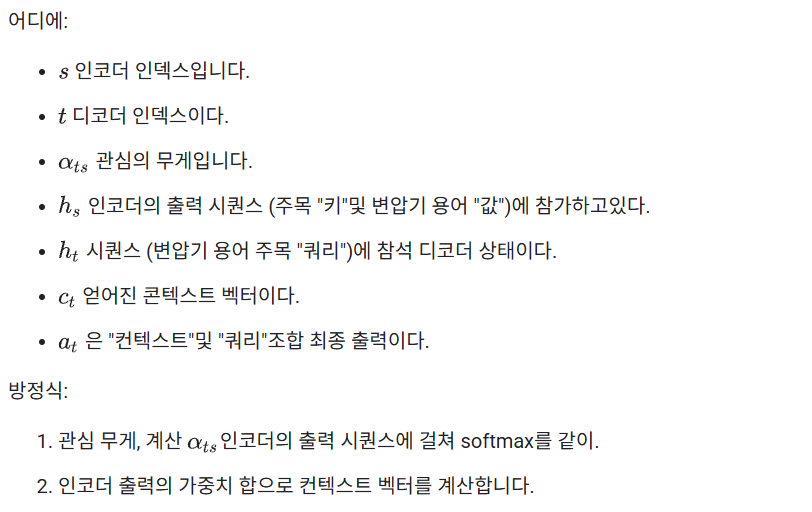
  </td>
</tr>
</table>

마지막은이다 ***score***
 기능. 그 작업은 각 키-쿼리 쌍에 대한 스칼라 로짓 점수를 계산하는 것입니다. 두 가지 일반적인 접근 방식이 있습니다.


 <table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/text/tutorials/images/attention_equation_4.jpg?hl=ko"/>
  </td>
</tr>
<tr>
  <th>A unidirectional RNN</th>
<tr>
</table>

이 튜토리얼은 사용 [Bahdanau의 첨가제 관심](https://arxiv.org/pdf/1409.0473.pdf)을 . TensorFlow은 모두 구현 포함 [`layers.Attention`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention?hl=ko&_gl=1*1h4lx4j*_up*MQ..*_ga*ODI4OTI5NTIyLjE3Mzk1MDE1NjM.*_ga_W0YLR4190T*MTczOTUwMTU2My4xLjAuMTczOTUwMTU2My4wLjAuMA..) 및 [`layers.AdditiveAttention`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention?hl=ko&_gl=1*1h4lx4j*_up*MQ..*_ga*ODI4OTI5NTIyLjE3Mzk1MDE1NjM.*_ga_W0YLR4190T*MTczOTUwMTU2My4xLjAuMTczOTUwMTU2My4wLjAuMA..) . 핸들 아래 클래스의 쌍 가중치 행렬 [`layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense?hl=ko&_gl=1*1h4lx4j*_up*MQ..*_ga*ODI4OTI5NTIyLjE3Mzk1MDE1NjM.*_ga_W0YLR4190T*MTczOTUwMTU2My4xLjAuMTczOTUwMTU2My4wLjAuMA..) 층, 및 내장 구현을 요구한다.

In [124]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    #for eqn. (4), the bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker=ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    #from eqn4, 'W1@ht'
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    #from eqn4, 'W2@hs'
    s2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores=True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights


어텐션 레이어 테스트

크리에이트 `BahdanauAttention` 레이어를 :

In [126]:
attention_layer = BahdanauAttention(UNITS)

이 레이어는 3개의 입력을 받습니다:

* query :이 나중에, 디코더에 의해 생성됩니다.
* value 이 인코더의 출력됩니다.
* mask : 패딩을 제외하려면 example_tokens != 0

In [127]:
(example_tokens != 0).shape

TensorShape([64, None])

In [134]:
example_tokens.to_list()

[[2, 1, 1, 1, 1, 11, 3],
 [2, 73, 1, 9, 1, 1, 1, 1, 4, 3],
 [2, 1, 1, 4, 3],
 [2, 73, 21, 1, 1, 287, 1, 1, 1, 1, 1177, 1, 4, 3],
 [2, 1, 1, 1, 1, 4, 3],
 [2, 9, 1, 1, 10, 1, 1, 4, 3],
 [2, 1, 1, 1, 4, 3],
 [2, 1, 1, 1, 1, 1749, 1, 1, 4, 3],
 [2, 1, 1, 1, 1, 1, 4, 3],
 [2, 73, 1, 1, 1, 4, 3],
 [2, 1, 73, 1, 1, 1, 4, 3],
 [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 3],
 [2, 9, 1, 10, 1, 1, 4, 3],
 [2, 73, 1, 1, 10, 1, 1, 4, 3],
 [2, 9, 1, 1, 1, 1, 1, 32, 1, 1, 1, 1, 1, 4, 3],
 [2, 1, 1, 1, 1, 1, 1, 1, 1, 917, 1, 4, 3],
 [2, 1, 1, 1, 1, 4, 3],
 [2, 73, 21, 1, 1, 1, 4, 3],
 [2, 13, 1, 1, 1, 1, 3091, 1, 1, 1, 1, 4, 3],
 [2, 10, 1, 1, 1, 1, 1, 4, 3],
 [2, 1, 1, 1, 4, 3],
 [2, 1, 1, 4, 3],
 [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 3],
 [2, 1, 1, 1, 1, 1, 1, 4, 3],
 [2, 1, 1, 1, 1, 10, 1, 1, 1, 4, 3],
 [2, 1, 1, 4, 3],
 [2, 73, 1, 1, 1, 1, 1, 1, 4, 3],
 [2, 1, 1, 1, 1, 4, 3],
 [2, 1, 1, 1, 1, 1, 1, 4, 3],
 [2, 1, 1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 4, 3],
 [2, 1, 1, 1, 1, 1, 1, 1, 1

어텐션 레이어의 벡터화된 구현을 통해 쿼리 벡터 시퀀스의 배치와 값 벡터 시퀀스의 배치를 전달할 수 있습니다. 결과는 다음과 같습니다.

1. 쿼리 크기의 결과 벡터 시퀀스 배치입니다.
2. 일괄주의는 크기, 매핑 `(query_length, value_length)` .

In [135]:
###

# latter, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens.to_list()), 2, 10])

#attend to the enceded tokens
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_token != 0)
)

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

NameError: name 'example_enc_output' is not defined

관심 가중치 합계는해야 `1.0` 각 시퀀스.

여기에서 시퀀스에서 관심의 무게입니다 `t=0`:

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

때문에 작은 임의 초기의 관심 가중치는 모든 가까운 `1/(sequence_length)` . 단일 순서의 무게에 확대하면 모델이 확장 배우고, 활용할 수있는 몇 가지 작은 변화가 있음을 알 수있다.

In [ ]:
 attention_weights.shape

In [ ]:
attention_slice = attention_seights[0,0].numpy()
attention_slice = attention_slice[attention_slice != 0]

In [ ]:
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

### 디코더

디코더의 작업은 다음 출력 토큰에 대한 예측을 생성하는 것입니다.
1. 디코더는 완전한 인코더 출력을 수신합니다.
2. RNN을 사용하여 지금까지 생성한 내용을 추적합니다.
3. RNN 출력을 인코더의 출력에 대한 주의에 대한 쿼리로 사용하여 컨텍스트 벡터를 생성합니다.
4. 그것은 "주의 벡터"를 생성하기 위해 식 3(아래)을 사용하여 RNN 출력과 컨텍스트 벡터를 결합합니다.
5. "주의 벡터"를 기반으로 다음 토큰에 대한 로짓 예측을 생성합니다.


<table>
<tr>
<td>
<img width=500 src='https://www.tensorflow.org/text/tutorials/images/attention_equation_3.jpg?hl=ko' />
</td>
</tr>
</table>

여기입니다 `Decoder` 클래스와 그 초기화. 이니셜라이저는 필요한 모든 레이어를 생성합니다.

In [208]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

#### 훈련

Next, the `call` method, takes 3 arguments:

* `inputs` -  a `context, x` pair where:
  * `context` - is the context from the encoder's output.
  * `x` - is the target sequence input.
* `state` - Optional, the previous `state` output from the decoder (the internal state of the decoder's RNN). Pass the state from a previous run to continue generating text where you left off.
* `return_state` - [Default: False] - Set this to `True` to return the RNN state.

In [209]:
@Decoder.add_method #저런식으로 사용한다는 이유가 뭘까? 클래스 안에 구현하지 않는 이유?
def call(self, context, x, state=None, return_state=False):
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  #1 lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  #2 process the target sequence
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  #3 use the rnn output as the query for the attention over the context
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  #4 generate logit predictions for the next token
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

That will be sufficient for training. Create an instance of the decoder to test out:

In [210]:
decoder = Decoder(target_text_processor, UNITS)

In training you'll use the decoder like this:

Given the context and target tokens, for each target token it predicts the next target token.

In [211]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'decoder_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


parsed: {'batch': 64, 't': 19}
self.shapes 0: {}
self.shapes: {}
self.shapes: {'batch': 64}
parsed: {'batch': 64, 's': 20, 'units': 256}
self.shapes 0: {'batch': 64, 't': 19}
self.shapes: {'batch': 64, 't': 19}
self.shapes: {'batch': 64, 't': 19}
self.shapes: {'batch': 64, 't': 19, 's': 20}
parsed: {'batch': 64, 't': 19, 'units': 256}
self.shapes 0: {'batch': 64, 't': 19, 's': 20, 'units': 256}
self.shapes: {'batch': 64, 't': 19, 's': 20, 'units': 256}
self.shapes: {'batch': 64, 't': 19, 's': 20, 'units': 256}
self.shapes: {'batch': 64, 't': 19, 's': 20, 'units': 256}
parsed: {'batch': 64, 't': 19, 'units': 256}
self.shapes 0: {'batch': 64, 't': 19, 's': 20, 'units': 256}
self.shapes: {'batch': 64, 't': 19, 's': 20, 'units': 256}
self.shapes: {'batch': 64, 't': 19, 's': 20, 'units': 256}
self.shapes: {'batch': 64, 't': 19, 's': 20, 'units': 256}
parsed: {'batch': 64, 't': 19, 'units': 256}
self.shapes 0: {}
self.shapes: {}
self.shapes: {'batch': 64}
self.shapes: {'batch': 64, 't': 19}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'cross_attention_8' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


#### Inference

To use it for inference you'll need a couple more methods:

In [223]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [213]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *&', '')
  return result

In [214]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(context, next_token, state = state, return_state=True)

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  #if a sequence produces an 'end_token', set it 'done
  done = done | (next_token == self.end_token)
  #once a sequence is donee it only produces 0-padding
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

With those extra functions, you can write a generation loop:

In [215]:
print(tf.shape(ex_context))
print(tf.shape(ex_context)[0])
print(tf.shape(ex_context)[0].numpy())

#tf.fill([batch_size, 1], self.start_token)
#done = tf.zeros([batch_size, 1], dtype=tf.bool)
#embedded = self.embedding(start_tokens)
#self.rnn = tf.keras.layers.GRU(units,
#                                   return_sequences=True,
#                                   return_state=True,
#                                   recurrent_initializer='glorot_uniform')
#self.embedding = tf.keras.layers.Embedding(self.vocab_size,
#                                               units, mask_zero=True)


'''
  batch_size = tf.shape(context)[0] #tf.Tensor(64, shape=(), dtype=int32)
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
'''
print('next',tf.fill([tf.shape(ex_context)[0]], '[START]'))
print('done', tf.zeros([tf.shape(ex_context)[0]], dtype=tf.bool))
'''print('state', tf.keras.layers.GRU(UNITS, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')(
    tf.fill([tf.shape(ex_context)[0], 1], '[START]')
))'''
batch = tf.shape(ex_context)[0]
start = tf.fill([batch, 1], '[START]')
emb = tf.keras.layers.Embedding(5000, 256, mask_zero=True)
print('state', emb(start))

tf.Tensor([ 64  20 256], shape=(3,), dtype=int32)
tf.Tensor(64, shape=(), dtype=int32)
64
next tf.Tensor(
[b'[START]' b'[START]' b'[START]' b'[START]' b'[START]' b'[START]'
 b'[START]' b'[START]' b'[START]' b'[START]' b'[START]' b'[START]'
 b'[START]' b'[START]' b'[START]' b'[START]' b'[START]' b'[START]'
 b'[START]' b'[START]' b'[START]' b'[START]' b'[START]' b'[START]'
 b'[START]' b'[START]' b'[START]' b'[START]' b'[START]' b'[START]'
 b'[START]' b'[START]' b'[START]' b'[START]' b'[START]' b'[START]'
 b'[START]' b'[START]' b'[START]' b'[START]' b'[START]' b'[START]'
 b'[START]' b'[START]' b'[START]' b'[START]' b'[START]' b'[START]'
 b'[START]' b'[START]' b'[START]' b'[START]' b'[START]' b'[START]'
 b'[START]' b'[START]' b'[START]' b'[START]' b'[START]' b'[START]'
 b'[START]' b'[START]' b'[START]' b'[START]'], shape=(64,), dtype=string)
done tf.Tensor(
[False False False False False False False False False False False False
 False False False False False False False False False False 

UnimplementedError: Exception encountered when calling Embedding.call().

[1m{{function_node __wrapped__Cast_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cast string to int32 is not supported [Op:Cast] name: [0m

Arguments received by Embedding.call():
  • inputs=tf.Tensor(shape=(64, 1), dtype=string)

In [224]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

InvalidArgumentError: {{function_node __wrapped__Pack_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [64,1,256] != values[1].shape = [] [Op:Pack] name: 

Since the model's untrained, it outputs items from the vocabulary almost uniformly at random.

## The model

Now that you have all the model components, combine them to build the model for training:

In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fnn

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    #build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(context_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #todo(b/250038731) :remove this  ## ()안에 무슨 뜻???
    try:
      #delete the keras mask, so keras doesn't sccale the loss+accuracy
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

During training the model will be used like this:

In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

### Train

For training, you'll want to implement your own masked loss and accuracy functions:

In [ ]:
def masked_loss(y_true, y_pred):
  #calculate the loss for each item in the batch
  loss_fn = tf.keras.lossses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none'
  )
  loss = loss_fn(y_true, y_pred)

  #mask off the losses on padding
  mask = tf.cast(y_true != 0, loss.dtype)
  loss *= mask

  #return the total
  return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
  #calculate the loss for each item in the batch
  y_pred = tf.argmax(y_pred, axis=-1)
  y_pred = tf.cast(y_pred, y_true.dtype)

  match = tf.cast(y_true == y_pred, tf.float32)
  mask = tf.cast(y_true != 0, tf.float32)

  return tf.reuce_sum(match)/tf.reduce_sum(mask)

Configure the model for training:

In [ ]:
nodel.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

That should roughly match the values returned by running a few steps of evaluation:

In [ ]:
model.evaluate(val_ds, steps=20, return_dict=True)

In [ ]:
history = model.fit(train_ds.repeat(),
                    epochs=100,
                    steps_per_epoch = 100,
                    validation_data = val_ds,
                    validation_steps=20,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(patient=3)
                    ])

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### Translate

Now that the model is trained, implement a function to execute the full `text => text` translation. This code is basically identical to the [inference example](#inference) in the [decoder section](#the_decoder), but this also captures the attention weights.

In [ ]:
#@title
@Translator.add_method
def translate(self, texts, *, max_length=50, temperature=0.0):
  #process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  #setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    #generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done, state, temperature
    )
    #collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  #stack the lists of tokens and attention weights
  tokens = tf.concat(tokens, axis=-1) #t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1) #t*[(batch 1 s)] -> (batch, t s)

  resule = self.decoder.tokens_to_text(tokens)
  return result

Here are the two helper methods, used above, to convert tokens to text, and to get the next token:

In [ ]:
result = model.translate(['¿Todavía está en casa?'])
result[0].numpy().decode()

Use that to generate the attention plot:

In [ ]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

In [ ]:
model.plot_attention('¿Todavía está en casa?')

Translate a few more sentences and plot them:

In [ ]:
%%time
model.plot_attention('Esta es mi vida')

In [ ]:
%%time
model.plot_attention('Tratar de descubrir.')

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state looses track of where it was in the context sequence there's no way for the model to recover. [Transformers](transformer.ipynb) improve on this by letting the decoder look at what it has output so far.

The `translate` function works on batches, so if you have multiple texts to translate you can pass them all at once, which is much more efficient than translating them one at a time:

In [ ]:
inputs = [
    'Hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life."
    'Su cuarto es un desastre.' # "His room is a mess"
]

In [ ]:
%%time
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

In [ ]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

So overall this text generation function mostly gets the job done, but so you've only used it here in python with eager execution. Let's try to export it next:

### Export

If you want to export this model you'll need to wrap the `translate` method in a `tf.function`. That implementation will get the job done:


In [ ]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [ ]:
export = Export(model)

Run the `tf.function` once to compile it:

In [ ]:
%%time
_ = export.translate(tf.constant(inputs))

In [ ]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

Now that the function has been traced it can be exported using `saved_model.save`:

In [ ]:
%%time
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default':export.translate})

In [ ]:
%%time
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

In [ ]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

#### [Optional] Use a dynamic loop

It's worth noting that this initial implementation is not optimal. It uses a python loop:

```
for _ in range(max_length):
  ...
  if tf.executing_eagerly() and tf.reduce_all(done):
    break
```

The python loop is relatively simple but when `tf.function` converts this to a graph, it **statically unrolls** that loop. Unrolling the loop has two disadvantages:

1. It makes `max_length` copies of the loop body. So the generated graphs take longer to build, save and load.
1. You have to choose a fixed value for the `max_length`.
1. You can't `break` from a statically unrolled loop. The `tf.function`
  version will run the full `max_length` iterations on every call.
  That's why the `break` only works with eager execution. This is
  still marginally faster than eager execution, but not as fast as it could be.


To fix these shortcomings, the `translate_dynamic` method, below, uses a tensorflow loop:

```
for t in tf.range(max_length):
  ...
  if tf.reduce_all(done):
      break
```

It looks like a python loop, but when you use a tensor as the input to a `for` loop (or the condition of a `while` loop) `tf.function` converts it to a dynamic loop using operations like `tf.while_loop`.

There's no need for a `max_length` here it's just in case the model gets stuck generating a loop like: `the united states of the united states of the united states...`.

On the down side, to accumulate tokens from this dynamic loop you can't just append them to a python `list`, you need to use a `tf.TensorArray`:

```
tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
...
for t in tf.range(max_length):
    ...
    tokens = tokens.write(t, next_token) # next_token shape is (batch, 1)
  ...
  tokens = tokens.stack()
  tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
```

This version of the code can be quite a bit more efficient:

In [ ]:
#@title
@Translator.add_method
def translate(self,
              texts,
              *,
              max_length=500,
              temperature=tf.constant(0,0)):
  shape_checker = ShapeChecker()
  context = self.encoder.convert_input(text)
  batch_size = tf.shape(context)[0]
  shape_checker(conetxt, 'batch s units')

  next_token, done, state = self.decoder.get_initial_state(context)

  #initialize the accumulator
  tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)

  for t in tf.tange(max_length):
    #generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done, state, temperature
    )
    shape_checker(next_token, 'batch t1')

    #collect the generated tokens
    tokens  tokens.write(t, next_token)

    #if all the sequences are done, break
    if tf.reduce_all(done):
      break

  #convert the list of generated token ids to a list of strings
  tokens = tokens.stack()
  shape_checker(tokens, 't batch t1')
  tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
  shape_checker(tokens, 'batch t')

  text = self.decoder.tokens_to_text(tokens)
  shape_checker(text, 'batch')

  return text

With eager execution this implementation performs on par with the original:

In [ ]:
%%time
result - model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

But when you wrap it in a `tf.function` you'll notice two differences.

In [ ]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string,shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [ ]:
export = Export(model)

First, it's much quicker to trace, since it only creates one copy of the loop body:

In [ ]:
%%time
_ = export.translate(inputs)

The `tf.function` is much faster than running with eager execution, and on small inputs it's often several times faster than the unrolled version, because it can break out of the loop.

In [ ]:
%%time
result = export.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

So save this version as well:

In [ ]:
%%time
tf.sved_model.save(export, 'dynamic_translator',
                   signature={'serving_default':export.translate})

In [ ]:
%%time
reloaded = tf.saved_model.load('dynamic_translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup #dho??warmup인것?

In [ ]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs.
* Try the [transformer tutorial](transformer.ipynb) which implements a similar translation task but uses transformer layers instead of RNNs. This version also uses a `text.BertTokenizer` to implement word-piece tokenization.
* Visit the [`tensorflow_addons.seq2seq` tutorial](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt), which demonstrates a higher-level functionality for implementing this sort of sequence-to-sequence model, such as `seq2seq.BeamSearchDecoder`.